<br><br><br> *Import pandas library for data manipulation

In [ ]:
import pandas as pd

# Load Titanic train dataset
data = pd.read_csv("/content/drive/MyDrive/gg/Titanic.csv")

# Show first 5 rows
print(data.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name  Gender   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


<br><br><br>
Data cleaning and feature engineering on Titanic dataset

In [ ]:
# Fill missing Age with median age
data['Age'] = data.groupby('Pclass')['Age'].transform(lambda x: x.fillna(x.median()))

# Fill missing Embarked with mode
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])

# Drop Cabin (too many missing values)
data.drop(columns=['Cabin'], inplace=True)

# Create new feature FamilySize = SibSp + Parch + 1 (self)
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

# Extract Title from Name
data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Simplify titles
data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',
    'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
data['Title'] = data['Title'].replace('Mlle', 'Miss')
data['Title'] = data['Title'].replace('Ms', 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')

print(data[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())


    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826


# Decision Tree


Entropy and Information Gain Analysis for Feature Selection in the Titanic Dataset



In [ ]:
from collections import Counter
import numpy as np
import pandas as pd

# Function to calculate entropy
def calculate_entropy(y):
    counts = Counter(y)
    total = len(y)
    entropy = 0
    for label in counts:
        p = counts[label] / total
        entropy -= p * np.log2(p)
    return entropy

# Function to calculate entropy after split
def calculate_split_entropy(X, y, feature):
    values = X[feature].unique()
    total = len(y)
    split_entropy = 0
    for val in values:
        subset_y = y[X[feature] == val]
        weight = len(subset_y) / total
        entropy = calculate_entropy(subset_y)
        split_entropy += weight * entropy
    return split_entropy


# Prepare data: include Title, drop NA, encode categorical variables
data_cleaned = data[['Survived', 'Gender', 'Age', 'Fare', 'Pclass', 'Embarked', 'Title']].dropna()

data_cleaned['Gender'] = data_cleaned['Gender'].map({'male': 0, 'female': 1})
data_cleaned['Embarked'] = data_cleaned['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# Encode Title as categorical numbers (e.g., via factorize)
data_cleaned['Title'], title_index = pd.factorize(data_cleaned['Title'])

# Bin Age and Fare
data_cleaned['Age'] = pd.cut(data_cleaned['Age'], bins=4, labels=[0,1,2,3])
data_cleaned['Fare'] = pd.qcut(data_cleaned['Fare'], q=4, labels=[0,1,2,3])

features = ['Gender', 'Age', 'Fare', 'Pclass', 'Embarked', 'Title']
X = data_cleaned[features]
y = data_cleaned['Survived']

base_entropy = calculate_entropy(y)
print(f"Base Entropy (Survived): {base_entropy:.4f}\n")

feature_stats = []
for feature in features:
    split_entropy = calculate_split_entropy(X, y, feature)
    info_gain = base_entropy - split_entropy
    feature_stats.append({
        'feature': feature,
        'split_entropy': split_entropy,
        'information_gain': info_gain
    })
    print(f"Feature: {feature}")
    print(f"  Entropy after split: {split_entropy:.4f}")
    print(f"  Information Gain: {info_gain:.4f}\n")

feature_stats = sorted(feature_stats, key=lambda x: x['information_gain'], reverse=True)
top_features = feature_stats[:3]

print("✅ Top 3 features for classification based on Information Gain:")
for i, f in enumerate(top_features, 1):
    print(f"  {i}. {f['feature']} (IG = {f['information_gain']:.4f})")


Base Entropy (Survived): 0.9607

Feature: Gender
  Entropy after split: 0.7430
  Information Gain: 0.2177

Feature: Age
  Entropy after split: 0.9547
  Information Gain: 0.0060

Feature: Fare
  Entropy after split: 0.8941
  Information Gain: 0.0666

Feature: Pclass
  Entropy after split: 0.8769
  Information Gain: 0.0838

Feature: Embarked
  Entropy after split: 0.9402
  Information Gain: 0.0205

Feature: Title
  Entropy after split: 0.7178
  Information Gain: 0.2429

✅ Top 3 features for classification based on Information Gain:
  1. Title (IG = 0.2429)
  2. Gender (IG = 0.2177)
  3. Pclass (IG = 0.0838)


<br><br><br>
Selecting Best Features for Survival Prediction Modeling

 Encode categorical features

In [ ]:
# Select features for modeling
features = ['Title', 'Gender', 'Pclass']
X = data[features].copy()
y = data['Survived']

X['Gender'] = X['Gender'].map({'male': 0, 'female': 1})
X['Title'], _ = pd.factorize(X['Title'])

# Show the first few rows of the top 3 features
print(data_cleaned[['Title','Gender','Pclass','Survived',]])

     Title  Gender  Pclass  Survived
0        0       0       3         0
1        1       1       1         1
2        2       1       3         1
3        1       1       1         1
4        0       0       3         0
..     ...     ...     ...       ...
886      4       0       2         0
887      2       1       1         1
888      2       1       3         0
889      0       0       1         1
890      0       0       3         0

[891 rows x 4 columns]


<br><br><br>
Training and Evaluating a Decision Tree Classifier


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier  # <--- Add this line

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Train Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Predict and evaluate
y_pred = dt.predict(X_test)
print(f"Decision Tree Accuracy: {accuracy_score(y_test, y_pred):.4f}")


Decision Tree Accuracy: 0.7542


<br><br><br>
Visualizing a Decision Tree Trained with Entropy Criterion

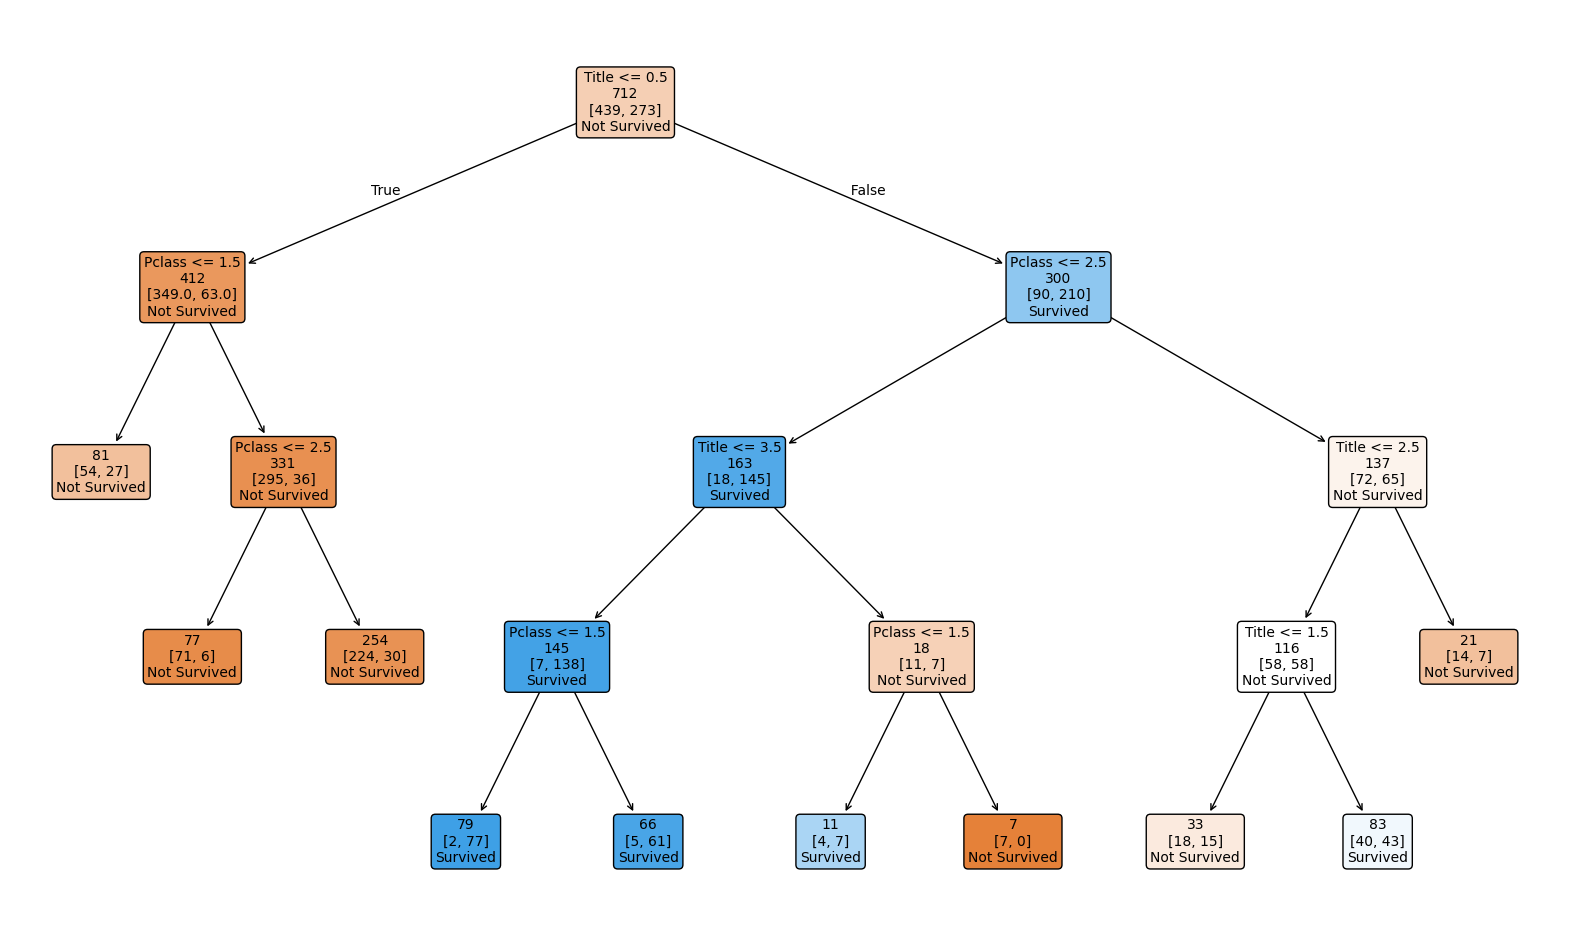

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Train without max depth limit
dt = DecisionTreeClassifier(random_state=42, criterion='entropy',max_depth=4)
dt.fit(X_train, y_train)

plt.figure(figsize=(20,12))  # Bigger figure for deeper tree
plot_tree(
    dt,
    feature_names=features,
    class_names=['Not Survived', 'Survived'],
    filled=True,
    rounded=True,
    fontsize=10,
    impurity=False,    # comma added here
    label='none'       # hide entropy, samples, values
)
plt.show()


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


test_acc_dt = dt.score(X_test, y_test)

def check_fit(train_acc, test_acc, model_name):
    print(f"{model_name} - Train Accuracy: {train_acc:.4f}")
    print(f"{model_name} - Test Accuracy: {test_acc:.4f}")

    diff = train_acc - test_acc

    if train_acc < 0.7 and test_acc < 0.7:
        print(f"{model_name} is underfitting. Both accuracies are low.\n")
    elif diff > 0.1:
        print(f"{model_name} is overfitting. Train accuracy is much higher than test accuracy.\n")
    else:
        print(f"{model_name} is well-fitted.\n")

# Example usage for Decision Tree
train_acc_dt = dt.score(X_train, y_train)
test_acc_dt = dt.score(X_test, y_test)
check_fit(train_acc_dt, test_acc_dt, "Decision Tree")

Decision Tree - Train Accuracy: 0.8090
Decision Tree - Test Accuracy: 0.7542
Decision Tree is well-fitted.



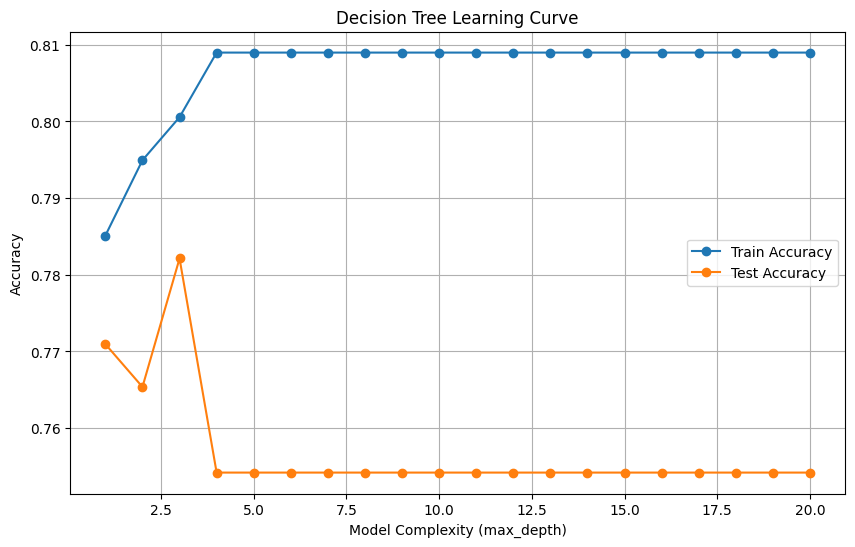

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

max_depths = range(1, 21)
train_accuracies = []
test_accuracies = []

for depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    train_accuracies.append(dt.score(X_train, y_train))
    test_accuracies.append(dt.score(X_test, y_test))

plt.figure(figsize=(10,6))
plt.plot(max_depths, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(max_depths, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Model Complexity (max_depth)')
plt.ylabel('Accuracy')
plt.title('Decision Tree Learning Curve')
plt.legend()
plt.grid(True)
plt.show()





# Random Forest

<br><br><br>
Titanic Survival Prediction Using Random Forest Classifier with Feature Encoding and Data Splitting

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Features and target
features = ['Title', 'Gender', 'Pclass', 'Age', 'Fare', 'Embarked', 'FamilySize']
X = data[features].copy()  # use copy to avoid SettingWithCopyWarning
y = data['Survived'].copy()

# Encode categorical variables
X['Gender'] = X['Gender'].map({'male': 0, 'female': 1})
X['Embarked'] = X['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
X['Title'], _ = pd.factorize(X['Title'])

# Drop any remaining missing values after encoding
X = X.dropna()
y = y.loc[X.index]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train Random Forest
rf = RandomForestClassifier(n_estimators=300, max_depth=8, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred):.4f}")


Random Forest Accuracy: 0.8268


<br><br><br>
Visualizing Feature Importance from a Random Forest Classifier on Titanic Dataset

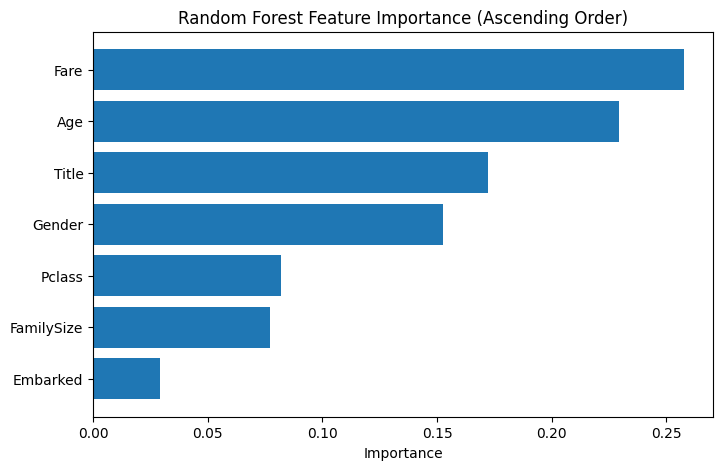

In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Make sure features is a list
features = list(features)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_

sorted_idx = np.argsort(importances)
sorted_features = [features[i] for i in sorted_idx]
sorted_importances = importances[sorted_idx]

plt.figure(figsize=(8,5))
plt.barh(sorted_features, sorted_importances)
plt.xlabel("Importance")
plt.title("Random Forest Feature Importance (Ascending Order)")
plt.show()


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# # Assume X, y are defined and preprocessed
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y)

# dt = DecisionTreeClassifier(random_state=42)
# dt.fit(X_train, y_train)

# train_acc_dt = dt.score(X_train, y_train)




def check_fit(train_acc, test_acc, model_name):
    print(f"{model_name} - Train Accuracy: {train_acc:.4f}")
    print(f"{model_name} - Test Accuracy: {test_acc:.4f}")

    diff = train_acc - test_acc

    if train_acc < 0.7 and test_acc < 0.7:
        print(f"{model_name} is underfitting. Both accuracies are low.\n")
    elif diff > 0.1:
        print(f"{model_name} is overfitting. Train accuracy is much higher than test accuracy.\n")
    else:
        print(f"{model_name} is well-fitted.\n")

# For Random Forest
train_acc_rf = rf.score(X_train, y_train)
test_acc_rf = rf.score(X_test, y_test)
check_fit(train_acc_rf, test_acc_rf, "Random Forest")


Random Forest - Train Accuracy: 0.9846
Random Forest - Test Accuracy: 0.8268
Random Forest is overfitting. Train accuracy is much higher than test accuracy.






# AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Base estimator for AdaBoost
base_dt = DecisionTreeClassifier(max_depth=1, random_state=42)

ada = AdaBoostClassifier(estimator=base_dt, n_estimators=50, random_state=42)
ada.fit(X_train, y_train)

y_pred = ada.predict(X_test)
print(f"AdaBoost Accuracy: {accuracy_score(y_test, y_pred):.4f}")


AdaBoost Accuracy: 0.8101


<br><br><br>
AdaBoost Classifier with Decision Tree Stumps for Titanic Survival Prediction


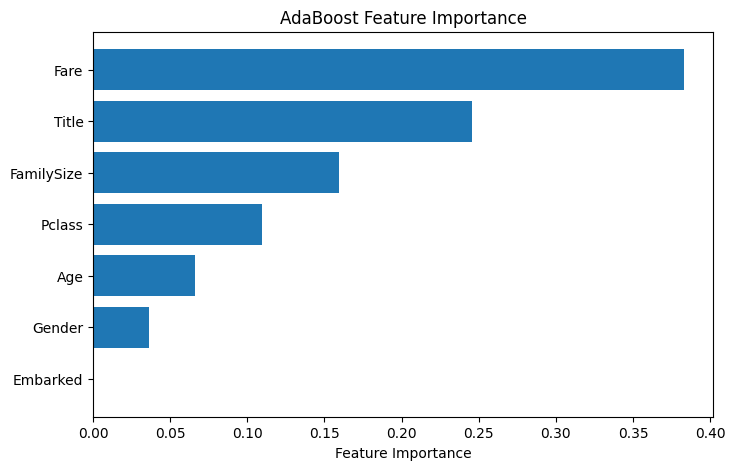

Fare: 0.3828
Title: 0.2459
FamilySize: 0.1595
Pclass: 0.1097
Age: 0.0659
Gender: 0.0362
Embarked: 0.0000


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

importances = ada.feature_importances_
sorted_idx = np.argsort(importances)
sorted_features = [features[i] for i in sorted_idx]
sorted_importances = importances[sorted_idx]

plt.figure(figsize=(8,5))
plt.barh(sorted_features, sorted_importances)
plt.xlabel("Feature Importance")
plt.title("AdaBoost Feature Importance")
plt.show()

# Print sorted features with importance values
for feat, imp in zip(sorted_features[::-1], sorted_importances[::-1]):
    print(f"{feat}: {imp:.4f}")


<br><br><br>
Visualizing Feature Importance of AdaBoost Classifier on Titanic Dataset

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Base estimator for AdaBoost
base_dt = DecisionTreeClassifier(max_depth=1, random_state=42)

# Initialize AdaBoost with base estimator
ada = AdaBoostClassifier(estimator=base_dt, n_estimators=50, random_state=42)

# Train AdaBoost model
ada.fit(X_train, y_train)

# Predict on test set
y_pred = ada.predict(X_test)

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"AdaBoost Accuracy: {accuracy:.4f}")


AdaBoost Accuracy: 0.8101


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split



def check_fit(train_acc, test_acc, model_name):
    print(f"{model_name} - Train Accuracy: {train_acc:.4f}")
    print(f"{model_name} - Test Accuracy: {test_acc:.4f}")

    diff = train_acc - test_acc

    if train_acc < 0.7 and test_acc < 0.7:
        print(f"{model_name} is underfitting. Both accuracies are low.\n")
    elif diff > 0.1:
        print(f"{model_name} is overfitting. Train accuracy is much higher than test accuracy.\n")
    else:
        print(f"{model_name} is well-fitted.\n")

# For AdaBoost
train_acc_ada = ada.score(X_train, y_train)
test_acc_ada = ada.score(X_test, y_test)
check_fit(train_acc_ada, test_acc_ada, "AdaBoost")


AdaBoost - Train Accuracy: 0.8343
AdaBoost - Test Accuracy: 0.8101
AdaBoost is well-fitted.

